<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [1]:
# if local
# !conda activate cs685

In [2]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [5]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [6]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection


In [7]:
# !git status

install requirements from repo 

In [8]:
# for colab, use venv if in local
!pip install -r requirements.txt
!pip3 install emoji

load the helper and dataloader files

In [9]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [10]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [11]:
import numpy as np
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      os.environ['PYTHONHASHSEED'] = str(seed)
      # safe to call this function even if cuda is not available
    if is_tf_available():
      import tensorflow as tf
      tf.random.set_seed(seed)


In [12]:

data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [13]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [14]:
# Stage 1 Annotations: see config.py for dataset specs
implicit_hate_dataset = Stage1Dataset(dataset_filename["stage-1"], merge_hate_labels=True, bertweet=True)

dataset_size = len(implicit_hate_dataset)
dataset_splits = [int(0.6*dataset_size), int(0.2*dataset_size), dataset_size - int(0.6*dataset_size) - int(0.2*dataset_size)]

# # Smaller dataset for testing model
# dataset_splits = [int(0.006*dataset_size), int(0.002*dataset_size), int(0.002*dataset_size)]
print("Dataset size", dataset_size)
print("Dataset splits", dataset_splits)

train_set, val_set, test_set = torch.utils.data.random_split(implicit_hate_dataset, dataset_splits)

train_dataloader =  DataLoader(train_set, batch_size=8, shuffle=False)
validation_dataloader = DataLoader(val_set, batch_size=8, shuffle=False)

# assert len(train_set) == int(0.6*dataset_size)
# assert len(val_set) == int(0.2*dataset_size)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Dataset size 21480
Dataset splits [12888, 4296, 4296]


In [15]:
# Confirming type is tensor
_, _, input_ids, attention_masks, labels = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [16]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# function to get validation accuracy
def get_validation_performance(model, val_set, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    validation_dataloader = DataLoader(val_set, batch_size=config["batch_size"], shuffle=True)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[2]
      input_mask_tensors = batch[3]
      label_tensors = batch[4]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    final_score = precision_recall_fscore_support(predicted, labels, average='binary')
    class_names=['not_hate', 'hate']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [25]:
!wandb login 

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [26]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "original-ppr-hparams-sweep",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [1e-5, 2e-5, 3e-5, 4e-5]
        },
        "random_seed" : {
          "values": [37, 69, 42]    
        },

        "epochs" : {
            "values" : [4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: 6pdpnx15
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/6pdpnx15


In [27]:
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = AutoModelForSequenceClassification.from_pretrained(
        "vinai/bertweet-base", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        set_seed(config['random_seed'])
        best_val = 0
        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader =  DataLoader(train_set, batch_size=config["batch_size"], shuffle=False)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[2]
                input_mask_tensors = batch[3]
                label_tensors = batch[4]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_set, config, epoch_i, "val")

            if val_acc > best_val:
              best_val = val_acc
              best_model = model
              best_lr = config["learning_rate"]
              best_randomseed = config["random_seed"]
              torch.save(model.state_dict(), 'best-model-parameters.pt')
              wandb.run.summary["best_lr"] = best_lr
              wandb.run.summary["best_randomseed"] = best_randomseed
              wandb.run.summary["best_val"] = best_val
              
            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(best_model, test_set, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy with best model: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: 8nqzqa1i with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 818.1954531222582


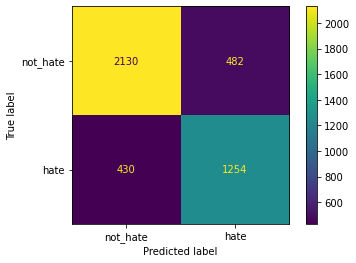

0.7446555819477435 0.7223502304147466 0.7333333333333334
Validation accuracy: 0.7877094972067039

======== Epoch 2 / 4 ========
Training...
Total loss: 609.579516351223


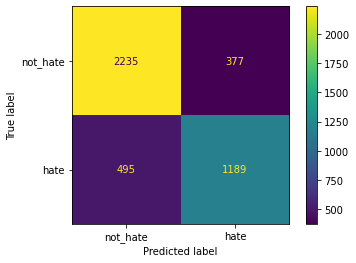

0.7060570071258907 0.7592592592592593 0.7316923076923078
Validation accuracy: 0.7970204841713222

======== Epoch 3 / 4 ========
Training...
Total loss: 482.36708499118686


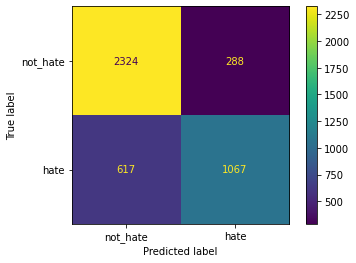

0.6336104513064132 0.7874538745387454 0.7022046725896676
Validation accuracy: 0.7893389199255121

======== Epoch 4 / 4 ========
Training...
Total loss: 363.0204822011292


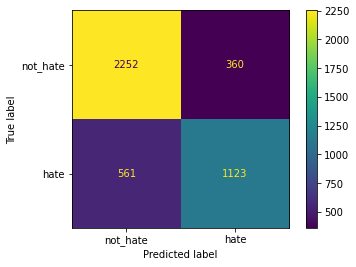

0.6668646080760094 0.7572488199595415 0.7091885064730028
Validation accuracy: 0.7856145251396648

Training complete!


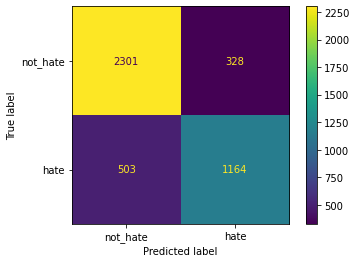

0.6982603479304139 0.7801608579088471 0.7369420702754035
Test accuracy with best model: 0.8065642458100558


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▆▅▄▄▇▄▃▄▃▆▄▃▃▂▃▄▃▆█▄▇▅▁▃▂▂▂▂▃▅▂▄▁▂▁▃▃▂▃▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▂█▃▁
val_f1,██▁▃
val_precision,█▆▁▃


wandb: Agent Starting Run: qo5ae6r1 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 812.8155310079455


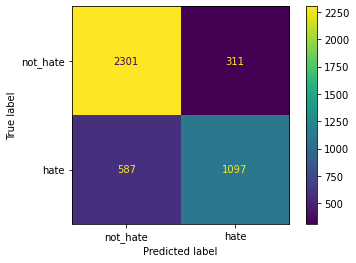

0.6514251781472684 0.7791193181818182 0.7095730918499354
Validation accuracy: 0.7909683426443203

======== Epoch 2 / 4 ========
Training...
Total loss: 598.4905751980841


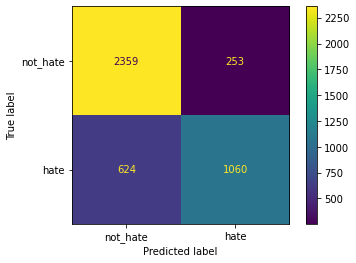

0.6294536817102138 0.8073115003808073 0.7073740407073741
Validation accuracy: 0.7958566108007449

======== Epoch 3 / 4 ========
Training...
Total loss: 450.6840129606426


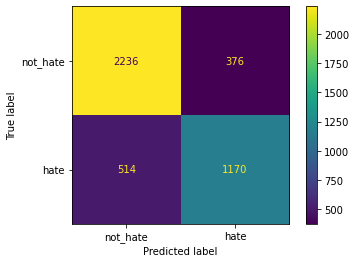

0.6947743467933492 0.7567917205692108 0.7244582043343653
Validation accuracy: 0.792830540037244

======== Epoch 4 / 4 ========
Training...
Total loss: 329.6438949285075


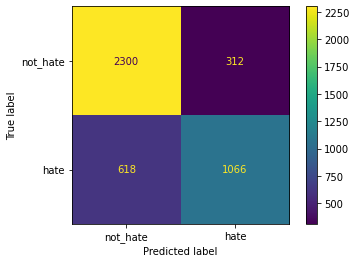

0.6330166270783848 0.7735849056603774 0.6962769431743958
Validation accuracy: 0.7835195530726257

Training complete!


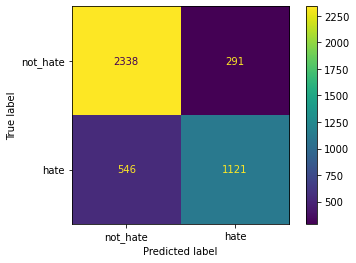

0.6724655068986203 0.7939093484419264 0.7281584930172134
Test accuracy with best model: 0.8051675977653632


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▅▄▃▅▄▃▃▃▅▄▂▃▂▄▅▃▅█▄▅▄▁▄▂▂▁▃▄▅▃▂▁▂▁▂▁▂▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▅█▆▁
val_f1,▄▄█▁
val_precision,▃▁█▁


wandb: Agent Starting Run: yu2iuh3q with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 818.787444807589


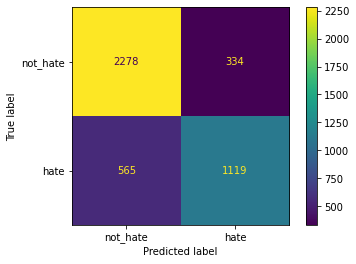

0.6644893111638955 0.7701307639366827 0.7134204654128148
Validation accuracy: 0.7907355679702048

======== Epoch 2 / 4 ========
Training...
Total loss: 611.1640186086297


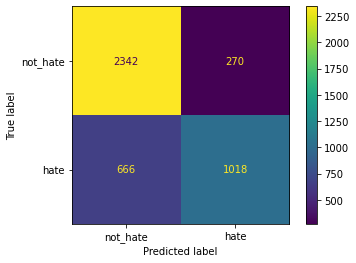

0.6045130641330166 0.7903726708074534 0.6850605652759084
Validation accuracy: 0.7821229050279329

======== Epoch 3 / 4 ========
Training...
Total loss: 469.8625519666821


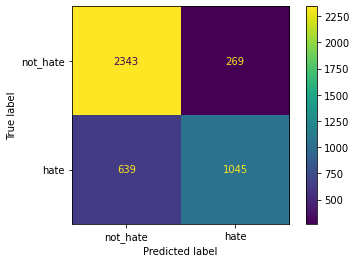

0.6205463182897862 0.7952815829528158 0.6971314209472982
Validation accuracy: 0.7886405959031657

======== Epoch 4 / 4 ========
Training...
Total loss: 332.821933359839


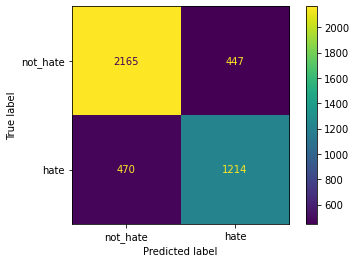

0.7209026128266033 0.7308850090307044 0.7258594917787742
Validation accuracy: 0.7865456238361266

Training complete!


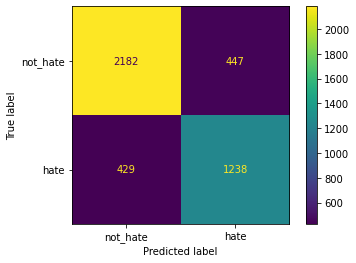

0.7426514697060588 0.7347181008902077 0.7386634844868735
Test accuracy with best model: 0.7960893854748603


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▅▄▃▅▃▄▄▃▆▄▂▂▃▃▆▂▅█▅▆▄▂▄▁▃▁▂▃▅▃▃▁▁▁▂▂▁▃▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▁▆▅
val_f1,▆▁▃█
val_precision,▅▁▂█


wandb: Agent Starting Run: 6prd7tl1 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 810.4660433828831


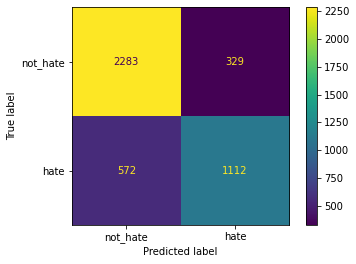

0.6603325415676959 0.7716863289382373 0.71168
Validation accuracy: 0.7902700186219739

======== Epoch 2 / 4 ========
Training...
Total loss: 588.563992280513


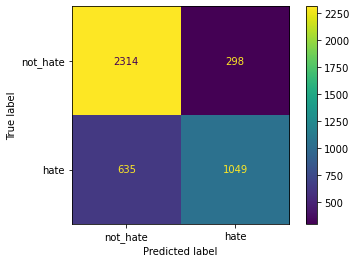

0.6229216152019003 0.7787676317743133 0.6921807984163643
Validation accuracy: 0.7828212290502793

======== Epoch 3 / 4 ========
Training...
Total loss: 429.93688681628555


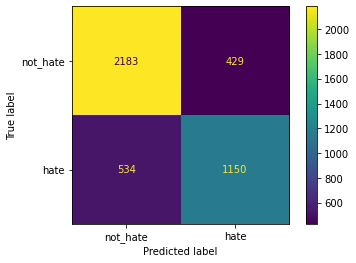

0.6828978622327792 0.7283090563647878 0.7048728164266014
Validation accuracy: 0.7758379888268156

======== Epoch 4 / 4 ========
Training...
Total loss: 300.17179134115577


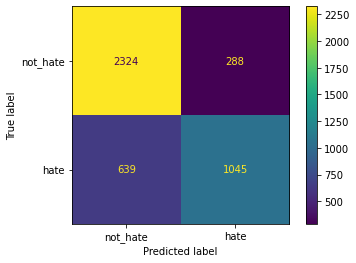

0.6205463182897862 0.7839459864966242 0.6927411335764004
Validation accuracy: 0.784217877094972

Training complete!


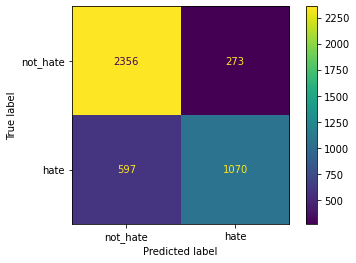

0.641871625674865 0.7967237527922562 0.7109634551495018
Test accuracy with best model: 0.797486033519553


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▆▅▄▄▆▄▃▄▃▅▅▂▃▁▃▃▃▅█▄▆▃▂▃▂▃▁▁▃▅▂▄▁▂▁▂▁▁▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▄▁▅
val_f1,█▁▆▁
val_precision,▅▁█▁


wandb: Agent Starting Run: 4ncmov82 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 1059.1060204207897


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


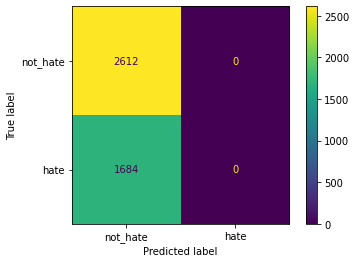

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 2 / 4 ========
Training...
Total loss: 1072.0432768464088


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


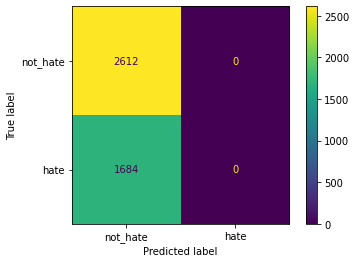

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 3 / 4 ========
Training...
Total loss: 1070.6439016759396


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


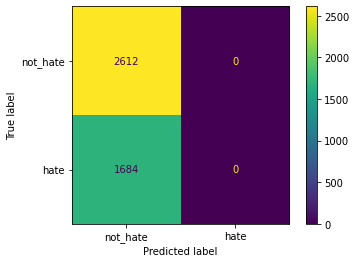

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 4 / 4 ========
Training...
Total loss: 1070.1390337646008


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


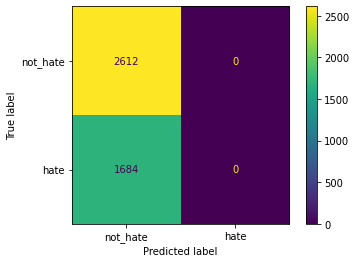

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


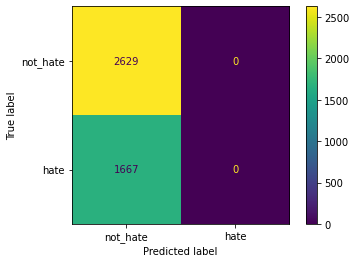

0.0 0.0 0.0
Test accuracy with best model: 0.6119646182495344


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▄▆█▃▅▇▁▂▃▅▅▇▄▂▆▆▄▄▃▃▆▄▅▂▄▅▃▄▄▄▃▅▅▂▆▄▄█▄▄
epoch,▁▁▁▁
loss,▁█▇▇
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▁▁▁
val_f1,▁▁▁▁
val_precision,▁▁▁▁


wandb: Agent Starting Run: 3ks21af7 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 804.9952455684543


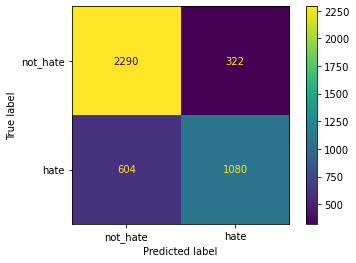

0.6413301662707839 0.7703281027104137 0.6999351911860013
Validation accuracy: 0.7844506517690876

======== Epoch 2 / 4 ========
Training...
Total loss: 590.7525380179286


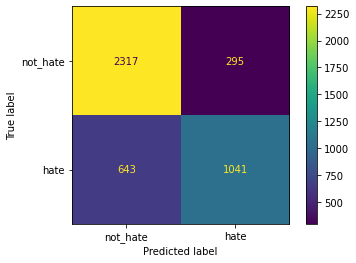

0.6181710213776722 0.7791916167664671 0.6894039735099338
Validation accuracy: 0.7816573556797021

======== Epoch 3 / 4 ========
Training...
Total loss: 422.7724292795174


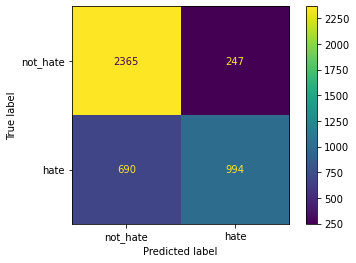

0.5902612826603325 0.8009669621273167 0.6796581196581196
Validation accuracy: 0.7818901303538175

======== Epoch 4 / 4 ========
Training...
Total loss: 298.9659047382884


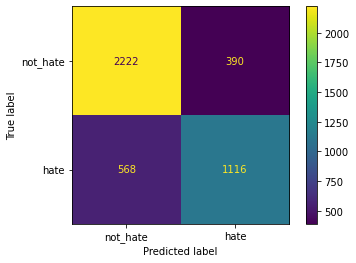

0.66270783847981 0.7410358565737052 0.6996865203761755
Validation accuracy: 0.777001862197393

Training complete!


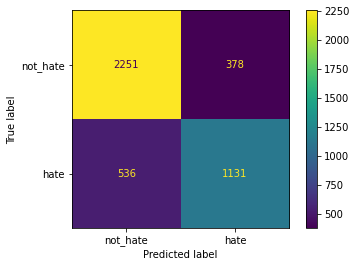

0.6784643071385723 0.7495029821073559 0.7122166246851385
Test accuracy with best model: 0.787243947858473


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▆▆▄▄█▄▅▅▄▆▆▂▂▂▅▇▄▇█▆▆▃▂▄▁▃▂▂▃▆▃▂▁▄▁▂▂▄▂▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▅▆▁
val_f1,█▄▁█
val_precision,▆▄▁█


wandb: Agent Starting Run: 8qxvcnxv with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 825.0598604157567


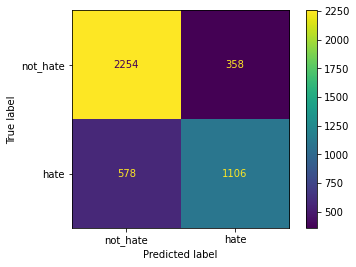

0.6567695961995249 0.755464480874317 0.7026683608640407
Validation accuracy: 0.7821229050279329

======== Epoch 2 / 4 ========
Training...
Total loss: 609.762144036591


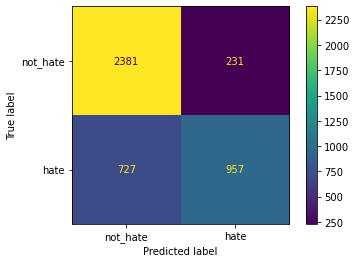

0.5682897862232779 0.8055555555555556 0.6664345403899721
Validation accuracy: 0.777001862197393

======== Epoch 3 / 4 ========
Training...
Total loss: 442.11560298036784


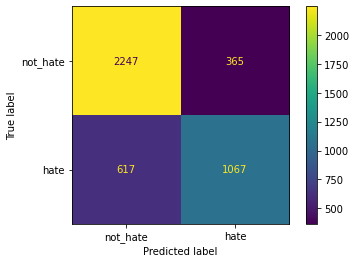

0.6336104513064132 0.7451117318435754 0.6848523748395378
Validation accuracy: 0.771415270018622

======== Epoch 4 / 4 ========
Training...
Total loss: 327.75144212832674


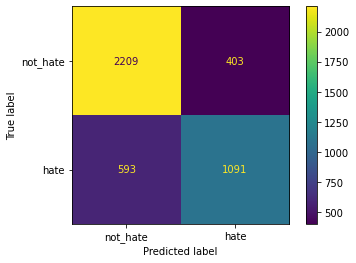

0.6478622327790974 0.7302543507362784 0.6865953429830081
Validation accuracy: 0.7681564245810056

Training complete!


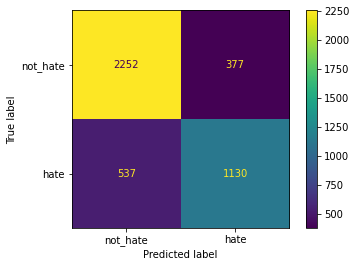

0.6778644271145771 0.7498341074983411 0.7120352867044739
Test accuracy with best model: 0.787243947858473


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▆▆▄▅▅▄▄▄▃▅▅▂▄▁▄█▃▆█▅▅▃▂▃▂▃▁▂▂█▃▃▁▁▁▂▁▂▃▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▅▃▁
val_f1,█▁▅▅
val_precision,█▁▆▇


wandb: Agent Starting Run: 01bj4p0z with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 820.3392267972231


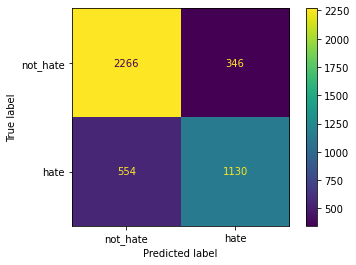

0.671021377672209 0.7655826558265583 0.7151898734177216
Validation accuracy: 0.7905027932960894

======== Epoch 2 / 4 ========
Training...
Total loss: 672.1307741887867


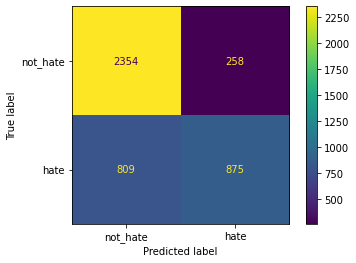

0.5195961995249406 0.7722859664607238 0.6212282570110046
Validation accuracy: 0.7516294227188082

======== Epoch 3 / 4 ========
Training...
Total loss: 739.0849452558905


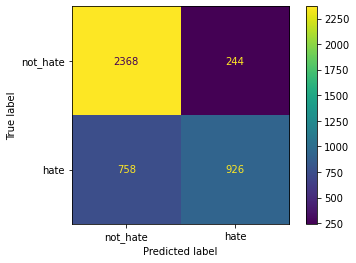

0.5498812351543944 0.7914529914529914 0.6489138051857043
Validation accuracy: 0.7667597765363129

======== Epoch 4 / 4 ========
Training...
Total loss: 482.8688858114183


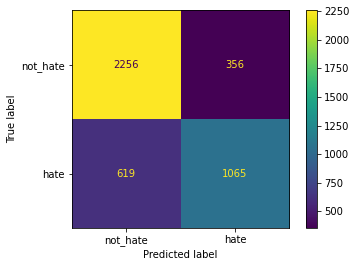

0.6324228028503563 0.7494722026741731 0.6859903381642513
Validation accuracy: 0.7730446927374302

Training complete!


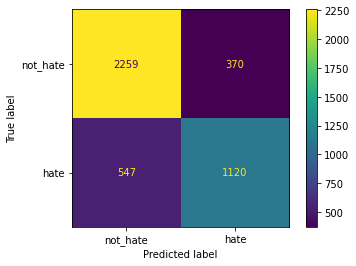

0.671865626874625 0.7516778523489933 0.7095343680709534
Test accuracy with best model: 0.7865456238361266


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▅▅▅▄▃▃▃▃▄▄▂▃▂▅▆▃▅█▃▅▃▂▃▂▆▄▄▄▅▃▃▃▃▁▄▃▂▃▂
epoch,▁▁▁▁
loss,█▅▆▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▁▄▅
val_f1,█▁▃▆
val_precision,█▁▂▆


wandb: Agent Starting Run: u6djwfpr with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 990.932899966836


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


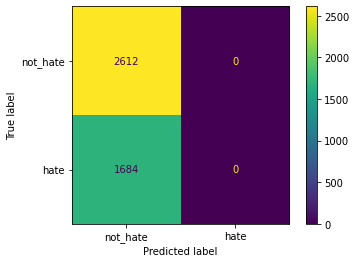

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 2 / 4 ========
Training...
Total loss: 1057.431277513504


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


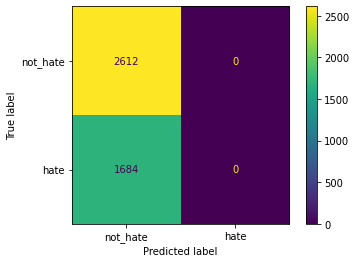

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 3 / 4 ========
Training...
Total loss: 1063.484850347042


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


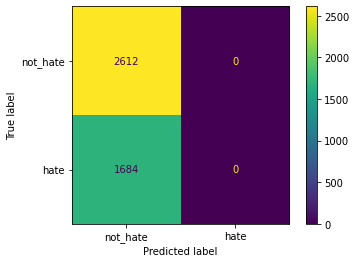

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 4 / 4 ========
Training...
Total loss: 1070.9750179350376


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


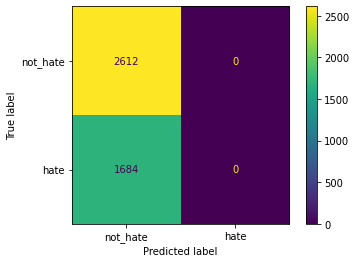

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


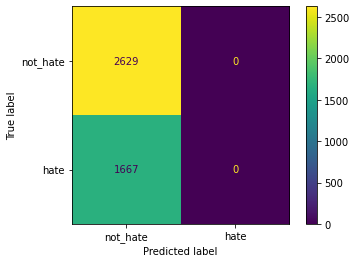

0.0 0.0 0.0
Test accuracy with best model: 0.6119646182495344


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▄▄█▄▅▄▂▁▄▅▅▇▅▃▅▆▃▆▄▄▅▅▆▃▄▅▄▅▅▄▄▅▅▃▆▅▄▇▄▄
epoch,▁▁▁▁
loss,▁▇▇█
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▁▁▁
val_f1,▁▁▁▁
val_precision,▁▁▁▁


wandb: Agent Starting Run: a42yhe93 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 861.3038557469845


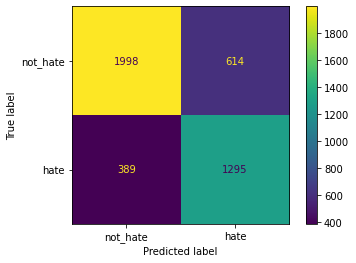

0.7690023752969121 0.678365636458879 0.7208460896187031
Validation accuracy: 0.7665270018621974

======== Epoch 2 / 4 ========
Training...
Total loss: 668.0852269791067


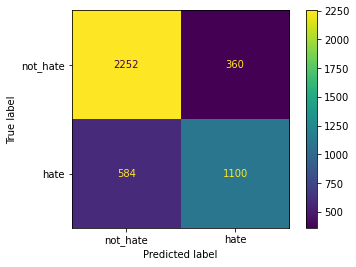

0.6532066508313539 0.7534246575342466 0.6997455470737913
Validation accuracy: 0.7802607076350093

======== Epoch 3 / 4 ========
Training...
Total loss: 523.6278404146433


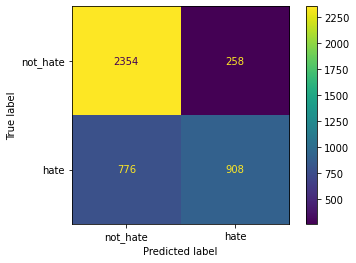

0.5391923990498813 0.7787307032590052 0.6371929824561403
Validation accuracy: 0.7593109869646183

======== Epoch 4 / 4 ========
Training...
Total loss: 403.2826964179985


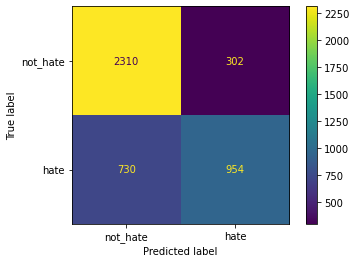

0.5665083135391924 0.7595541401273885 0.6489795918367346
Validation accuracy: 0.7597765363128491

Training complete!


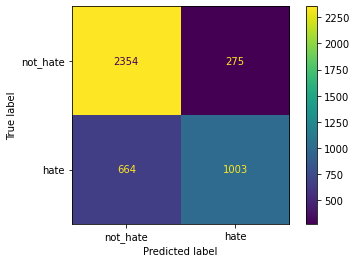

0.6016796640671865 0.7848200312989045 0.6811544991511035
Test accuracy with best model: 0.7814245810055865


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▄▄▄▃▄▃▃▃▂▄▃▁▃▂▃▅▃▄█▄▅▄▂▄▃▂▁▂▂▅▃▃▁▁▁▄▁▂▁▂
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▃█▁▁
val_f1,█▆▁▂
val_precision,█▄▁▂


wandb: Agent Starting Run: qwck0up4 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 852.4475390687585


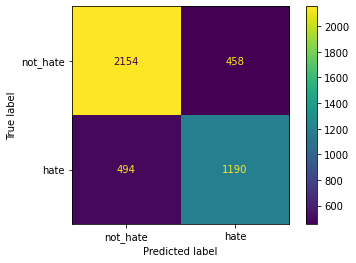

0.7066508313539193 0.7220873786407767 0.7142857142857143
Validation accuracy: 0.7783985102420856

======== Epoch 2 / 4 ========
Training...
Total loss: 1042.2317873984575


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


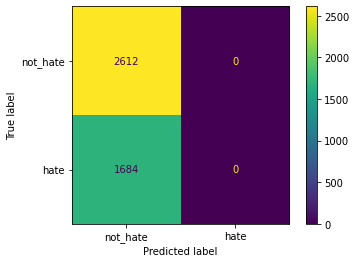

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 3 / 4 ========
Training...
Total loss: 1072.5082380473614


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


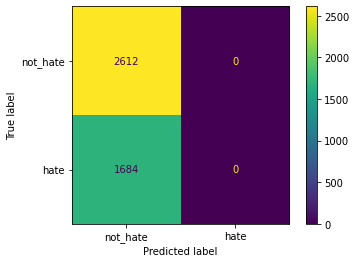

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 4 / 4 ========
Training...
Total loss: 1071.1112871170044


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


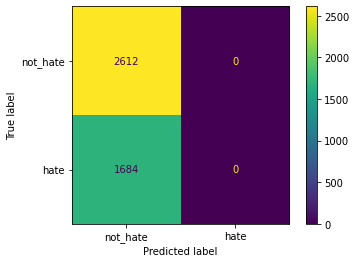

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


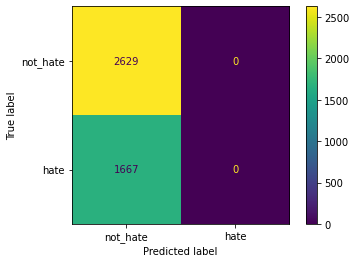

0.0 0.0 0.0
Test accuracy with best model: 0.6119646182495344


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▅▅▄▄▄▂▃▂▄▄▁▆▄▇▇▆▆▅▅▇▆▆▄▆▆▅▆▆▅▅▆▆▄▇▆▅█▅▅
epoch,▁▁▁▁
loss,▁▇██
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▁▁▁
val_f1,█▁▁▁
val_precision,█▁▁▁


wandb: Agent Starting Run: nb5zw7s4 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 


======== Epoch 1 / 4 ========
Training...
Total loss: 1078.2184454500675


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


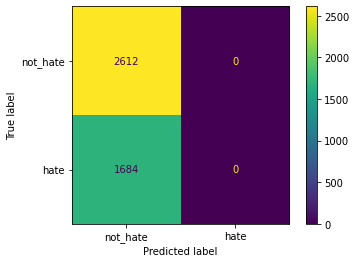

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 2 / 4 ========
Training...
Total loss: 1072.8227968513966


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


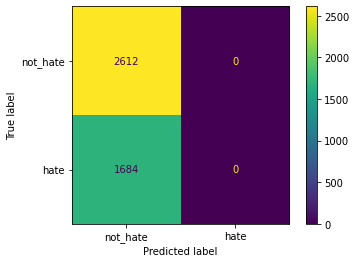

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 3 / 4 ========
Training...
Total loss: 1070.6057550013065


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


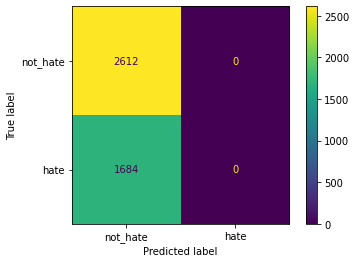

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

======== Epoch 4 / 4 ========
Training...
Total loss: 1070.5304419100285


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


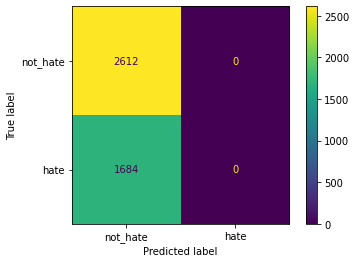

0.0 0.0 0.0
Validation accuracy: 0.6080074487895717

Training complete!


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


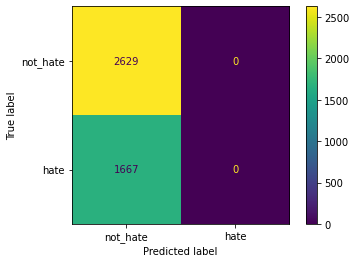

0.0 0.0 0.0
Test accuracy with best model: 0.6119646182495344


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▄▅▆▃▅▅▁▂▂▄▄▇▄▁▅▅▄▄▂▃▅▃▄▁▃▄▂▃▄▃▂▄▄▁▅▄▂█▃▃
epoch,▁▁▁▁
loss,█▃▁▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▁▁▁
val_f1,▁▁▁▁
val_precision,▁▁▁▁


In [28]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")